# Automatically generating object masks with SAM

[![image](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb)
[![image](https://img.shields.io/badge/Open-Planetary%20Computer-black?style=flat&logo=microsoft)](https://pccompute.westeurope.cloudapp.azure.com/compute/hub/user-redirect/git-pull?repo=https://github.com/opengeos/segment-geospatial&urlpath=lab/tree/segment-geospatial/docs/examples/automatic_mask_generator.ipynb&branch=main)
[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb)

This notebook shows how to segment objects from an image using the Segment Anything Model (SAM) with a few lines of code.

Make sure you use GPU runtime for this notebook. For Google Colab, go to `Runtime` -> `Change runtime type` and select `GPU` as the hardware accelerator.

The notebook is adapted from [segment-anything/notebooks/automatic_mask_generator_example.ipynb](https://github.com/opengeos/segment-anything/blob/pypi/notebooks/automatic_mask_generator_example.ipynb), but I have made it much easier to save the segmentation results and visualize them.

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [1]:
%pip install segment-geospatial leafmap localtileserver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of requests[socks] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.31.0 which is incompatible.


In [2]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

## Create an interactive map

In [11]:
m = leafmap.Map(center=[22.97271, 120.19699], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[22.97271, 120.19699], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [12]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2659, 37.8682, -122.2521, 37.8741]

## Download a sample image

You can also use your own image. Uncomment and run the following cell to use your own image.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

TileSourceError: ignored

In [9]:
!pip install localtileserver

In [24]:
image = '/content/drive/MyDrive/project_NanShang/3_1.tif'

Display the downloaded image on the map.

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [15]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=None,
)

Checkpoint /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth does not exist.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:13<00:00, 186MB/s]


## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object.

In [25]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

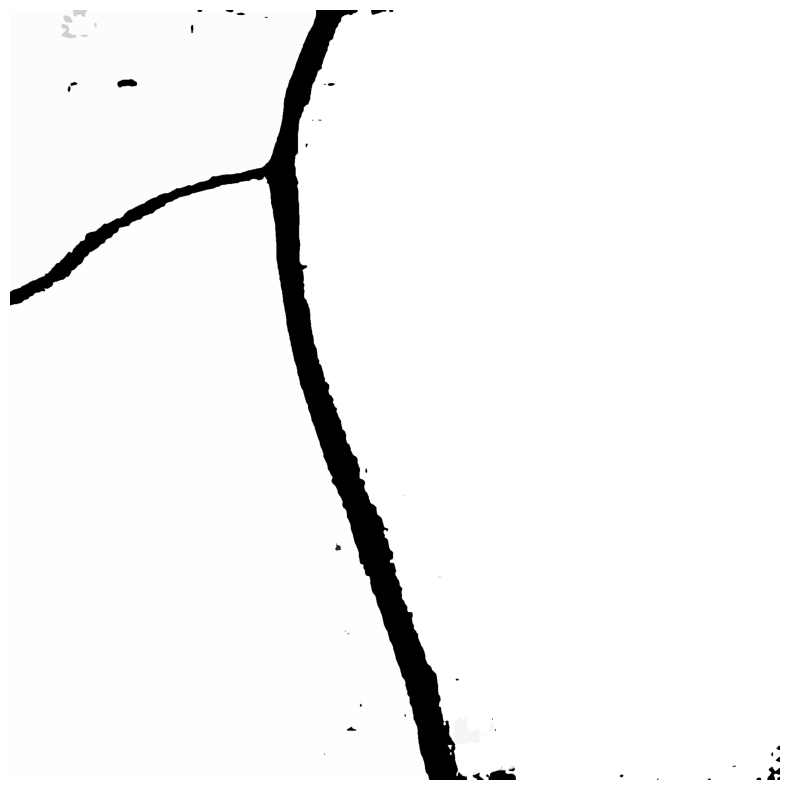

In [26]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

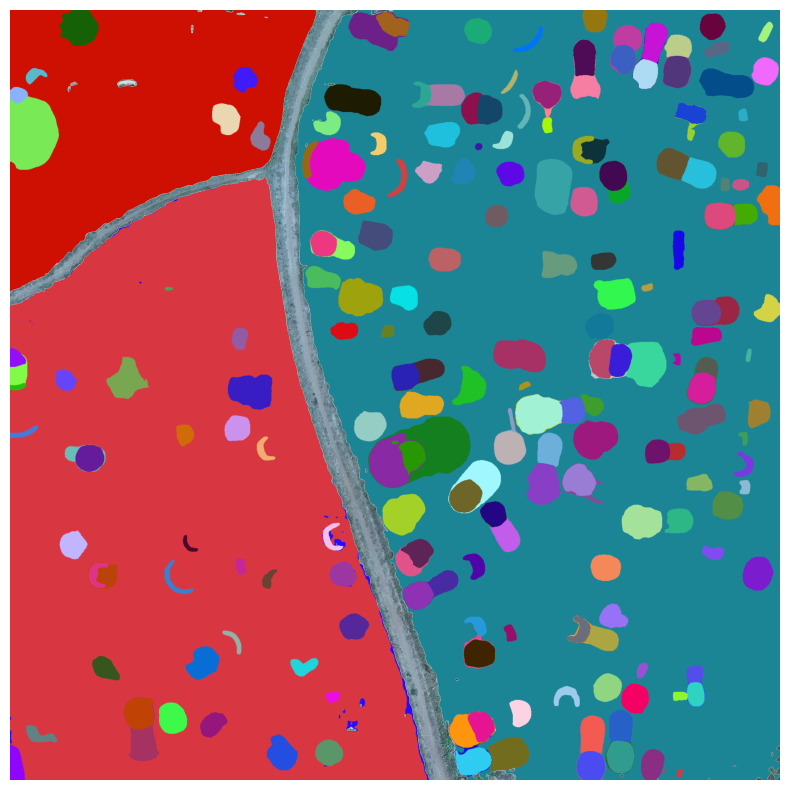

In [27]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")

Compare images with a slider.

In [19]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

FileNotFoundError: ignored

Add image to the map.

In [ ]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [ ]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=sam_kwargs,
)

In [ ]:
sam.generate(image, output="masks2.tif", foreground=True)

In [ ]:
sam.show_masks(cmap="binary_r")

In [ ]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")

Compare images with a slider.

In [ ]:
leafmap.image_comparison(
    image,
    "annotations.tif",
    label1="Image",
    label2="Image Segmentation",
)

Overlay the annotations on the image and use the slider to change the opacity interactively.

In [ ]:
overlay_images(image, "annotations2.tif", backend="TkAgg")

![](https://i.imgur.com/I1IhDgz.gif)